# Creates all plots

1. [Plots of Occupation old](#occupation_old)
2. [Plots of Occupation new](#occupation_new)
3. [Plots of Transformation old](#transformation_old)
4. [Plots of Transformation new](#transformation_new)

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import textwrap

<a id="occupation_old"></a>
## Occupation old

In [32]:
main_df_oc_old = pd.read_pickle("lca_occupation_results_old.pkl")
print("Dataframe loaded!")

Dataframe loaded!


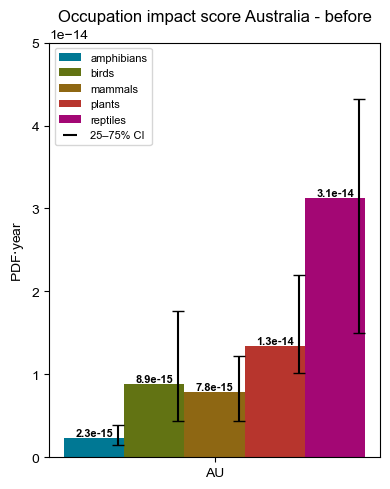

In [33]:
#========================================================
# Code for the plot: occupation_CFs_by_location_AU_old
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Impact score by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_oc_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Occupation impact score Australia - before")
ax_b.set_ylabel("PDF$\cdot$year")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)
ax_b.set_ylim(0, 5e-14) 

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_AU_old.png", dpi=150)
plt.show()

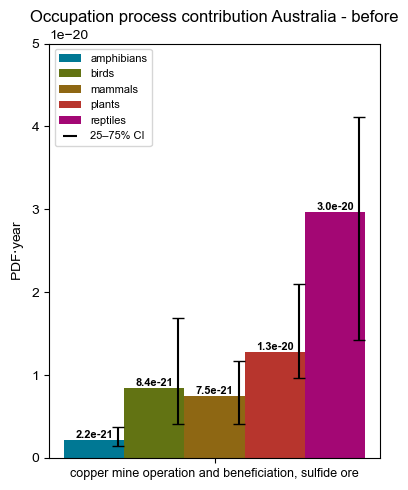

In [34]:
#========================================================
# Code for the plot: occupation_CFs_by_process_AU_copper_old
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution (Specific AU Processes)
# =========================================================
# Reduced width slightly since it's likely a single group
fig, ax_c = plt.subplots(figsize=(4, 5))

# --- Data Prep ---
df_c = main_df_oc_old.copy()

# 1. Filter for Australia
df_c = df_c[df_c["consumer location"] == "AU"].copy()

# 2. Define the EXACT target processes
target_processes = [
    'copper mine operation and beneficiation, sulfide ore'
]

# 3. Filter
df_c = df_c[df_c["consumer name"].isin(target_processes)]

# 4. Create label column
df_c["plot_label"] = df_c["consumer name"]

# Flags for error bars
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Sort order
top_labels = [t for t in target_processes if t in df_c["plot_label"].unique()]

if not top_labels:
    print("WARNING: No data found for these processes in AU. Check exact spelling.")

# Aggregation
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group
gb_c = (df_c
        .groupby(["plot_label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["plot_label"] = pd.Categorical(gb_c["plot_label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["plot_label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("plot_label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        val_lower = vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        val_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values
        
        y = np.nan_to_num(y)
        val_lower = np.nan_to_num(val_lower)
        val_upper = np.nan_to_num(val_upper)
        
        err_lower = y - val_lower
        err_upper = val_upper - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    bar_color = custom_colors[i % len(custom_colors)]

    # 1. Plot MAIN BAR (no yerr here)
    bars = ax_c.bar(positions, y, width=bar_width_c, 
             label=str(meth), color=bar_color)
    
    # 2. Plot ERROR BAR at the right edge
    if has_imp_percentiles:
        # X position = Center + Half Width
        error_x = positions + (bar_width_c / 2.5)
        
        ax_c.errorbar(error_x, y, yerr=errors, 
                      fmt='none', ecolor='black', elinewidth=1.5, capsize=4)

    # 3. Add TEXT LABELS on top of the bar
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        
        # Place text at bar height
        y_pos = bar.get_height()
        
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # Center X
            y_pos,                              # Top Y
            f"{val:.1e}",                       # Scientific notation
            ha='center', va='bottom',           # Bottom align so it sits ON the bar
            fontsize=8, color='black', fontweight='bold'
        )

# --- Formatting ---
wrapped_labels = [textwrap.fill(lbl, 60) for lbl in top_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(wrapped_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Occupation process contribution Australia - before")
ax_c.set_ylabel("PDF$\cdot$year")
ax_c.set_ylim(0, 5e-20)

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_AU_copper_old.png", dpi=150)
plt.show()

<a id="occupation_new"></a>
## Occupation new

In [35]:
main_df_oc_new = pd.read_pickle("lca_occupation_results_new.pkl")
print("Dataframe loaded!")

Dataframe loaded!


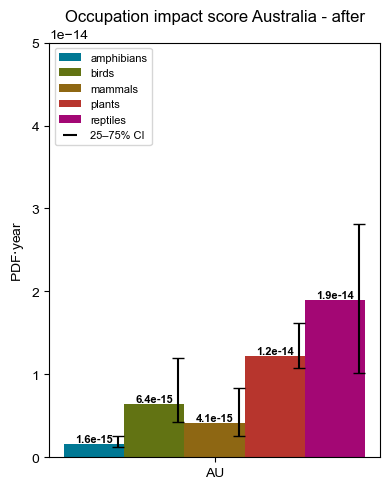

In [36]:
#========================================================
# Code for the plot: occupation_CFs_by_location_AU_new
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Impact score by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_oc_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Occupation impact score Australia - after")
ax_b.set_ylabel("PDF$\cdot$year")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)
ax_b.set_ylim(0, 5e-14)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_AU_new.png", dpi=150)
plt.show()

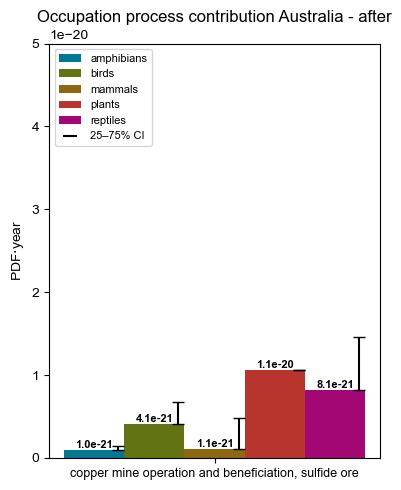

In [37]:
#========================================================
# Code for the plot: occupation_CFs_by_process_AU_copper_new
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution (Specific AU Processes)
# =========================================================
# Reduced width slightly since it's likely a single group
fig, ax_c = plt.subplots(figsize=(4, 5))

# --- Data Prep ---
df_c = main_df_oc_new.copy()

# 1. Filter for Australia
df_c = df_c[df_c["consumer location"] == "AU"].copy()

# 2. Define the EXACT target processes
target_processes = [
    'copper mine operation and beneficiation, sulfide ore'
]

# 3. Filter
df_c = df_c[df_c["consumer name"].isin(target_processes)]

# 4. Create label column
df_c["plot_label"] = df_c["consumer name"]

# Flags for error bars
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Sort order
top_labels = [t for t in target_processes if t in df_c["plot_label"].unique()]

if not top_labels:
    print("WARNING: No data found for these processes in AU. Check exact spelling.")

# Aggregation
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group
gb_c = (df_c
        .groupby(["plot_label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["plot_label"] = pd.Categorical(gb_c["plot_label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["plot_label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("plot_label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        val_lower = vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        val_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values
        
        y = np.nan_to_num(y)
        val_lower = np.nan_to_num(val_lower)
        val_upper = np.nan_to_num(val_upper)
        
        err_lower = y - val_lower
        err_upper = val_upper - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    bar_color = custom_colors[i % len(custom_colors)]

    # 1. Plot MAIN BAR (no yerr here)
    bars = ax_c.bar(positions, y, width=bar_width_c, 
             label=str(meth), color=bar_color)
    
    # 2. Plot ERROR BAR at the right edge
    if has_imp_percentiles:
        # X position = Center + Half Width
        error_x = positions + (bar_width_c / 2.5)
        
        ax_c.errorbar(error_x, y, yerr=errors, 
                      fmt='none', ecolor='black', elinewidth=1.5, capsize=4)

    # 3. Add TEXT LABELS on top of the bar
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        
        # Place text at bar height
        y_pos = bar.get_height()
        
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # Center X
            y_pos,                              # Top Y
            f"{val:.1e}",                       # Scientific notation
            ha='center', va='bottom',           # Bottom align so it sits ON the bar
            fontsize=8, color='black', fontweight='bold'
        )

# --- Formatting ---
wrapped_labels = [textwrap.fill(lbl, 60) for lbl in top_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(wrapped_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Occupation process contribution Australia - after")
ax_c.set_ylabel("PDF$\cdot$year")
ax_c.set_ylim(0, 5e-20)

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_AU_copper_new.png", dpi=150)
plt.show()

### Check data

In [38]:
import pandas as pd

# 1. Setup Data
df_check = main_df_oc_new.copy()

# 2. Filter for the specific context (AU + Copper Mine)
target_process = 'copper mine operation and beneficiation, sulfide ore'
df_check = df_check[
    (df_check["consumer location"] == "AU") & 
    (df_check["consumer name"] == target_process)
]

# 3. Define the columns you want to inspect
cols_to_check = [
    'impact (25th)', 
    'impact (50th)', 
    'impact (mean)', 
    'impact (75th)'
]

# 4. Group by Method and SUM (just like the plot does)
#    We sum because "process impact" = sum of all input impacts
debug_table = df_check.groupby("method")[cols_to_check].sum().reset_index()

# 5. Calculate the relative difference to see how close they actually are
#    (Gap between 75th and 25th as a % of the Median)
debug_table['Spread (%)'] = (
    (debug_table['impact (75th)'] - debug_table['impact (25th)']) 
    / debug_table['impact (50th)']
) * 100

print("--- Data Verification for Plot ---")
print(f"Process: {target_process} (AU)")
print(debug_table.to_string())

--- Data Verification for Plot ---
Process: copper mine operation and beneficiation, sulfide ore (AU)
       method  impact (25th)  impact (50th)  impact (mean)  impact (75th)  Spread (%)
0  amphibians   1.004063e-21   1.004063e-21   1.510050e-21   1.382006e-21   37.641430
1       birds   4.061933e-21   4.061933e-21   6.416885e-21   6.793176e-21   67.239980
2     mammals   1.082989e-21   1.082989e-21   3.914090e-21   4.808453e-21  343.998465
3      plants   1.064705e-20   1.064705e-20   1.646570e-20   1.064705e-20    0.000000
4    reptiles   8.148170e-21   8.148170e-21   1.746830e-20   1.455286e-20   78.602756


In [39]:
import pandas as pd

# 1. Setup Data
df_cfs = main_df_oc_new.copy()

# 2. Filter for the specific context (AU + Copper Mine)
target_process = 'copper mine operation and beneficiation, sulfide ore'
df_cfs = df_cfs[
    (df_cfs["consumer location"] == "AU") & 
    (df_cfs["consumer name"] == target_process)
]

# 3. Define columns to inspect
#    We look at Supplier (the substance), Amount (how much was used), 
#    CF (the intensity factor), and Impact (the result)
columns_to_show = [
    'method',
    'supplier name', 
    'supplier categories', 
    'amount', 
    'CF (mean)', 
    'CF (50th)',     # Median CF often used in MC analysis
    'impact (mean)'  # To see which one matters most
]

# 4. Sort by Impact 
#    This puts the most relevant CFs (the ones driving the bar chart) at the top
df_debug_cfs = df_cfs[columns_to_show].sort_values(by='impact (mean)', ascending=False)

print(f"--- CFs Used for: {target_process} (AU) ---")
print(df_debug_cfs.head(15).to_string(index=False))

--- CFs Used for: copper mine operation and beneficiation, sulfide ore (AU) ---
    method                       supplier name      supplier categories       amount    CF (mean)    CF (50th)  impact (mean)
  reptiles Occupation, mineral extraction site (natural resource, land) 9.528072e-07 1.833351e-14 8.551752e-15   1.746830e-20
    plants Occupation, mineral extraction site (natural resource, land) 9.528072e-07 1.728126e-14 1.117440e-14   1.646570e-20
     birds Occupation, mineral extraction site (natural resource, land) 9.528072e-07 6.734715e-15 4.263122e-15   6.416885e-21
   mammals Occupation, mineral extraction site (natural resource, land) 9.528072e-07 4.107956e-15 1.136629e-15   3.914090e-21
amphibians Occupation, mineral extraction site (natural resource, land) 9.528072e-07 1.584843e-15 1.053794e-15   1.510050e-21


<a id="transformation_old"></a>
## Transformation old

In [40]:
main_df_tra_old = pd.read_pickle("lca_transformation_results_old.pkl")
print("Dataframe loaded!")

Dataframe loaded!


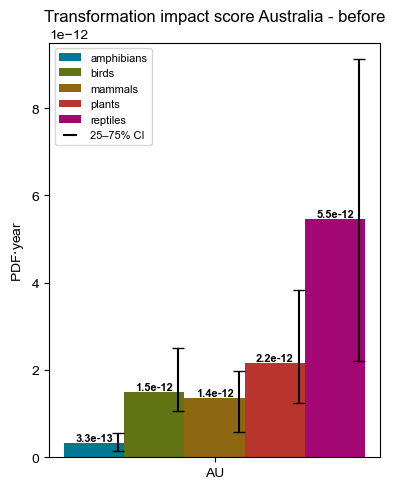

In [41]:
#========================================================
# Code for the plot: transformation_CFs_by_location_AU_old
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Impact score by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_tra_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Transformation impact score Australia - before")
ax_b.set_ylabel("PDF$\cdot$year")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)
ax_b.set_ylim(0, 9.5e-12)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_AU_old.png", dpi=150)
plt.show()

<a id="transformation_new"></a>
## Transformation new

In [42]:
main_df_tra_new = pd.read_pickle("lca_transformation_results_new.pkl")
print("Dataframe loaded!")

Dataframe loaded!


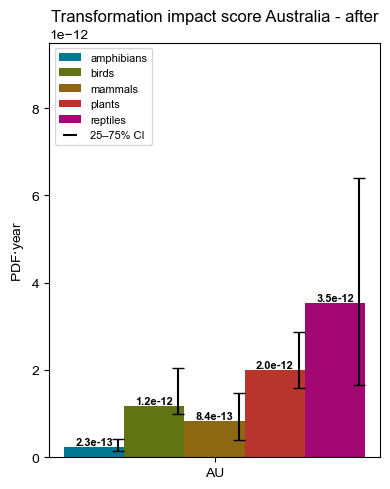

In [43]:
#========================================================
# Code for the plot: transformation_CFs_by_location_AU_new
#========================================================

# ETH color configuration
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Impact score by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_tra_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Transformation impact score Australia - after")
ax_b.set_ylabel("PDF$\cdot$year")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)
ax_b.set_ylim(0, 9.5e-12)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_AU_new.png", dpi=150)
plt.show()

## Uncertainty explanation

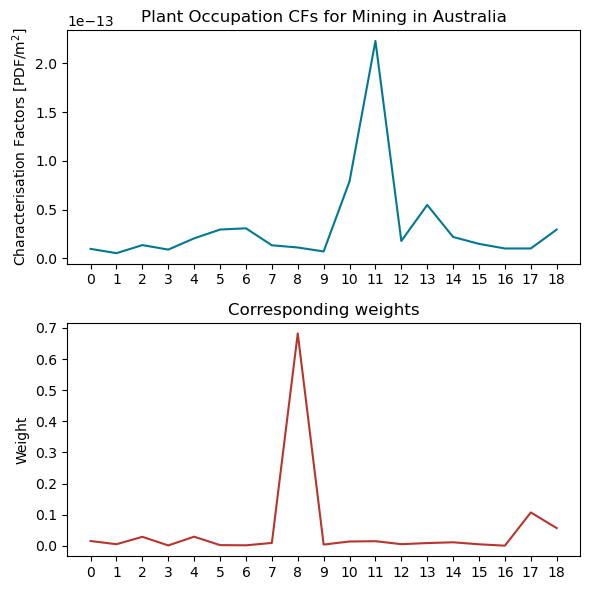

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
values = [
  9.752031929890522e-15, 5.3619333856399004e-15, 1.3632746456881e-14, 9.02342095914209e-15,
  2.0546575704921e-14, 2.95726125347631e-14, 3.0841422657898604e-14, 1.34503075785065e-14,
  1.1174403741729e-14, 7.1243470314089e-15, 7.90278460233485e-14, 2.22921679232136e-13,
  1.78397961581553e-14, 5.47934575346732e-14, 2.19617507270845e-14, 1.4891131106306102e-14,
  1.01641753975621e-14, 1.01831700313193e-14, 2.95626096209773e-14
]
weights = [
  0.015261438328250672, 0.004997861679822948, 0.02868238721936061, 0.001100267176463875,
  0.02915098674682948, 0.0020639227690514624, 0.001462398443291509, 0.009070997044825242,
  0.6822150123432238, 0.003860533143317762, 0.013721694853378015, 0.014663887631527038,
  0.005104782575831615, 0.008668935350607218, 0.01114646911458409, 0.004732122546561445,
  0.0003120588513098558, 0.10699998964910798, 0.05678425453265547
]

# Create plots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Define x-axis ticks (Integers 0 to 18)
x_ticks = np.arange(0, 19, 1)

# Plot Values
axs[0].plot(values, marker='', linestyle='-', color="#007894")
axs[0].set_title('Plant Occupation CFs for Mining in Australia')
axs[0].set_ylabel('Characterisation Factors [PDF/m$^2$]')
axs[0].set_xticks(x_ticks) # Sets specific integer ticks
axs[0].grid(False)

# Plot Weights
axs[1].plot(weights, marker='', linestyle='-', color="#b7352d")
axs[1].set_title('Corresponding weights')
axs[1].set_ylabel('Weight')
axs[1].set_xticks(x_ticks) # Sets specific integer ticks
axs[1].grid(False)

plt.tight_layout()
plt.savefig('Plots/uncertainty_plants.png')

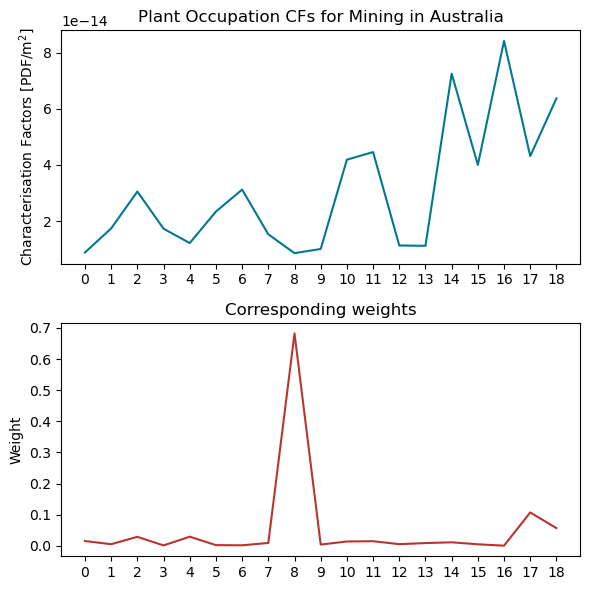

In [24]:
# Reptiles
values = [
    8.791736331505851e-15, 1.7374419710423802e-14, 3.0515703288388e-14, 1.7273197784622e-14,
    1.2152381620237e-14, 2.33916386634097e-14, 3.12012938548222e-14, 1.52736645532828e-14,
    8.55175190173465e-15, 1.0041025520789401e-14, 4.18753431267774e-14, 4.45932402406324e-14,
    1.1292232556544501e-14, 1.1166358795355e-14, 7.25419683418218e-14, 3.99974105563869e-14,
    8.42041092124221e-14, 4.31344927209346e-14, 6.37334822772782e-14
]
weights = [
    0.015261438328250672, 0.004997861679822948, 0.02868238721936061,  0.001100267176463875,
    0.02915098674682948,  0.0020639227690514624, 0.001462398443291509, 0.009070997044825242,
    0.6822150123432238, 0.003860533143317762, 0.013721694853378015, 0.014663887631527038,
    0.005104782575831615, 0.008668935350607218, 0.01114646911458409, 0.004732122546561445,
    0.0003120588513098558, 0.10699998964910798, 0.05678425453265547
]

# Create plots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Define x-axis ticks (Integers 0 to 18)
x_ticks = np.arange(0, 19, 1)

# Plot Values
axs[0].plot(values, marker='', linestyle='-', color="#007894")
axs[0].set_title('Plant Occupation CFs for Mining in Australia')
axs[0].set_ylabel('Characterisation Factors [PDF/m$^2$]')
axs[0].set_xticks(x_ticks) # Sets specific integer ticks
axs[0].grid(False)

# Plot Weights
axs[1].plot(weights, marker='', linestyle='-', color="#b7352d")
axs[1].set_title('Corresponding weights')
axs[1].set_ylabel('Weight')
axs[1].set_xticks(x_ticks) # Sets specific integer ticks
axs[1].grid(False)

plt.tight_layout()
plt.savefig('Plots/uncertainty_reptiles.png')